# AlexNet Model Implementation

Based on the following paper: [ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)

### Implementation Detail:
The implementation made in this program follows the original paper closely but added the following modern techniques:
1. LeakyReLU activation functions
2. AdaDelta optimizer
3. Kaiming Initialization (implicitly, pytorch uses kaiming_uniform as default initializer for convolutional layer)

### Architecture
**Backbone**
1. Convolutional Layer (Conv2d -> Leaky ReLU -> BatchNorm2d)
2. Convolutional Layer
3. Convolutional Layer

**Neck**  
5. Flatten

**Head**  
6. Fully Connected ( Linear -> Leaky ReLU -> Dropout)  
7. Fully Connected (Linear -> Leaky ReLU -> Dropout)

### Dataset

Uses ImageNette (a smaller subset of The ImageNet dataset) available from [fastai](https://github.com/fastai/imagenette) or [pytorch](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html)  
ImageNette consists of images with the following class label
```
        "n01440764": ("tench", "Tinca tinca"),
        "n02102040": ("English springer", "English springer spaniel"),
        "n02979186": ("cassette player",),
        "n03000684": ("chain saw", "chainsaw"),
        "n03028079": ("church", "church building"),
        "n03394916": ("French horn", "horn"),
        "n03417042": ("garbage truck", "dustcart"),
        "n03425413": ("gas pump", "gasoline pump", "petrol pump", "island dispenser"),
        "n03445777": ("golf ball",),
        "n03888257": ("parachute", "chute"),
```

## Code

## Loading Libraries

In [1]:
# Top level package
import torch
import torchvision

# Image augmentation operations
from torchvision.transforms import v2

# NN-layers
from torch import nn

# Activation functions
import torch.nn.functional as F

# Optimizers
import torch.optim as optim

# Data reader and loader
from torch.utils.data import TensorDataset, DataLoader

# Evaluation suite
import torchmetrics

# Imagenette utils
from torchvision.datasets import Imagenette

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# numpy
import numpy as np

# pandas
import pandas as pd

# setting random seed for replicability
torch.manual_seed(7)

## Loading & Reading Dataset

### Defining Image Augmentations

In [2]:
# autoaugment policy from https://arxiv.org/abs/1805.09501 
# https://pytorch.org/vision/main/generated/torchvision.transforms.v2.AutoAugment.html
policy = v2.AutoAugmentPolicy.IMAGENET

# resize to 227 x 227 -> autoaugment -> turn to tensor
custom_transforms = v2.Compose([
    v2.Resize(size=(227, 227)),
    v2.AutoAugment(policy=policy),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

convert_to_tensor = v2.Compose([
    v2.Resize(size=(227, 227)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

### Loading Training and Testing Data

In [3]:
filepath = "E:/Current_Workdir/Portfolios/CNN-on-Imagenette/dataset"

In [4]:
imagenette_train = Imagenette(filepath, split="train", transform=custom_transforms)
imagenette_train

Dataset Imagenette
    Number of datapoints: 9469
    Root location: E:/Current_Workdir/Portfolios/CNN-on-Imagenette/dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[227, 227], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.IMAGENET)
                 ToImage()
                 ToDtype(scale=True)
           )

In [5]:
imagenette_test = Imagenette(filepath, split="val", transform=convert_to_tensor)
imagenette_test

Dataset Imagenette
    Number of datapoints: 3925
    Root location: E:/Current_Workdir/Portfolios/CNN-on-Imagenette/dataset
    StandardTransform
Transform: Compose(
                 Resize(size=[227, 227], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToImage()
                 ToDtype(scale=True)
           )

### Creating Data Loader

In [6]:
batch_size = 64

In [7]:
train_dataloader = DataLoader(imagenette_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(imagenette_test, batch_size=batch_size, shuffle=True)

### Inspecting Sample Data

In [8]:
label_dict = {
    0: "tench",
    1: "English springer",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "French horn",
    6: "garbage truck",
    7: "gas pump",
    8: "golf ball",
    9: "parachute"
}

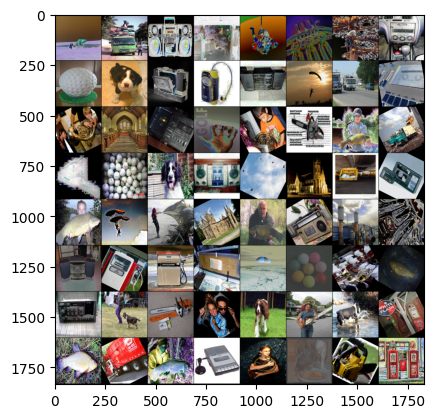

['parachute', 'garbage truck', 'cassette player', 'chain saw', 'parachute', 'French horn', 'chain saw', 'cassette player', 'golf ball', 'English springer', 'cassette player', 'cassette player', 'cassette player', 'parachute', 'garbage truck', 'cassette player', 'French horn', 'church', 'cassette player', 'golf ball', 'French horn', 'chain saw', 'tench', 'garbage truck', 'chain saw', 'golf ball', 'English springer', 'cassette player', 'parachute', 'church', 'garbage truck', 'cassette player', 'tench', 'parachute', 'parachute', 'church', 'tench', 'cassette player', 'gas pump', 'French horn', 'cassette player', 'gas pump', 'gas pump', 'cassette player', 'parachute', 'golf ball', 'French horn', 'tench', 'cassette player', 'English springer', 'chain saw', 'cassette player', 'English springer', 'chain saw', 'English springer', 'gas pump', 'tench', 'garbage truck', 'tench', 'cassette player', 'French horn', 'English springer', 'chain saw', 'gas pump']


In [9]:
# Training Data
# get some random training images
train_dataiter = iter(train_dataloader)
train_images, train_labels = next(train_dataiter)

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(train_images))
# print labels
print([label_dict[train_labels[j].item()] for j in range(batch_size)])

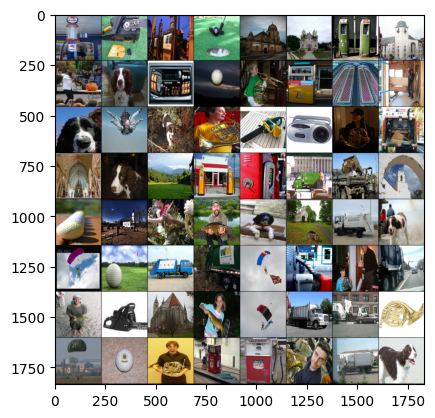

['gas pump', 'chain saw', 'gas pump', 'golf ball', 'church', 'church', 'gas pump', 'church', 'chain saw', 'English springer', 'cassette player', 'golf ball', 'French horn', 'gas pump', 'church', 'chain saw', 'English springer', 'parachute', 'English springer', 'French horn', 'chain saw', 'cassette player', 'French horn', 'garbage truck', 'church', 'English springer', 'golf ball', 'gas pump', 'gas pump', 'garbage truck', 'garbage truck', 'church', 'golf ball', 'church', 'French horn', 'tench', 'English springer', 'church', 'garbage truck', 'English springer', 'parachute', 'golf ball', 'garbage truck', 'garbage truck', 'parachute', 'gas pump', 'French horn', 'garbage truck', 'tench', 'chain saw', 'church', 'tench', 'parachute', 'garbage truck', 'garbage truck', 'French horn', 'parachute', 'golf ball', 'French horn', 'gas pump', 'gas pump', 'French horn', 'garbage truck', 'English springer']


In [10]:
# Testing Data
# get some random testing images
test_dataiter = iter(test_dataloader)
test_images, test_labels = next(test_dataiter)

# show images
imshow(torchvision.utils.make_grid(test_images))
# print labels
print([label_dict[test_labels[j].item()] for j in range(batch_size)])

## Defining Model

### Model Architecture

In [11]:
# Model architecture
class AlexNet(nn.Module):
    def __init__(self, num_target_class):
        super().__init__()
        self.backbone = nn.Sequential(
            # first convolutional block
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            # second convolutional block
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            # third convolutional block
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        self.head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Linear(4096, num_target_class),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = x.reshape(x.size(0), -1)
        x = self.head(x)
        return x

In [12]:
 # Instantiating the model
net = AlexNet(num_target_class=10)
net

AlexNet(
  (backbone): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (13): BatchNorm

### Loss Function

In [13]:
loss_function = nn.CrossEntropyLoss()
loss_function

CrossEntropyLoss()

### Optimizer

In [14]:
optimizer = optim.SGD(net.parameters(), lr = 0.001)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Configuring Device (GPU / CPU)

In [15]:
# use GPU if available, if not then use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Metric

In [16]:
# define eval metrics
# multiclass accuracy top-1
metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, top_k = 1)
metric.to(device)

MulticlassAccuracy()

## Training

### Loading Model to Device

In [17]:
net.to(device)

AlexNet(
  (backbone): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (13): BatchNorm

### Epoch Finder

In [18]:
# specify number of epoch
epoch = 20

In [19]:
train_loss = []
test_loss = []

In [20]:
for epoch in range(epoch):    
    running_training_loss = 0.0
    running_testing_loss = 0.0
    
    for i, data in enumerate(train_dataloader, 0):
        # move data to device
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the gradient parameters
        optimizer.zero_grad()
        # forward propagation
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        # backward propagation
        loss.backward()
        optimizer.step()
        # add batch loss to the running loss
        running_training_loss += loss.item()

    # calculate average of running loss for this epoch
    # and append to train_loss
    avg_training_loss = running_training_loss / len(train_dataloader)
    train_loss.append(avg_training_loss)
    print(f'Epoch [{epoch + 1}]), Training Loss: {avg_training_loss:.4f}')

    # calculating testing loss
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            running_testing_loss += loss.item()

        avg_testing_loss = running_testing_loss / len(test_dataloader)
        test_loss.append(avg_testing_loss)
        print(f'Epoch [{epoch + 1}]), Testing Loss: {avg_testing_loss:.4f}')
        
print('Epoch Finder Finished')

Epoch [1]), Training Loss: 2.3046
Epoch [1]), Testing Loss: 2.2898
Epoch [2]), Training Loss: 2.2908
Epoch [2]), Testing Loss: 2.2794
Epoch [3]), Training Loss: 2.2777
Epoch [3]), Testing Loss: 2.2538
Epoch [4]), Training Loss: 2.2570
Epoch [4]), Testing Loss: 2.2226
Epoch [5]), Training Loss: 2.2264
Epoch [5]), Testing Loss: 2.1743
Epoch [6]), Training Loss: 2.1968
Epoch [6]), Testing Loss: 2.1231
Epoch [7]), Training Loss: 2.1556
Epoch [7]), Testing Loss: 2.0666
Epoch [8]), Training Loss: 2.1212
Epoch [8]), Testing Loss: 2.0168
Epoch [9]), Training Loss: 2.0716
Epoch [9]), Testing Loss: 1.9689
Epoch [10]), Training Loss: 2.0293
Epoch [10]), Testing Loss: 1.9131
Epoch [11]), Training Loss: 1.9879
Epoch [11]), Testing Loss: 1.8606
Epoch [12]), Training Loss: 1.9472
Epoch [12]), Testing Loss: 1.8110
Epoch [13]), Training Loss: 1.8922
Epoch [13]), Testing Loss: 1.7400
Epoch [14]), Training Loss: 1.8408
Epoch [14]), Testing Loss: 1.6794
Epoch [15]), Training Loss: 1.7871
Epoch [15]), Test

In [21]:
train_loss

[2.3046203142887838,
 2.290801745814246,
 2.277726676013019,
 2.2570183534879944,
 2.2263745311144234,
 2.196813754133276,
 2.1555657998935596,
 2.1211859769112356,
 2.0715875907524213,
 2.02933252099398,
 1.987907667417784,
 1.9471504237200763,
 1.8922127420837815,
 1.8408438949971586,
 1.7871398635812707,
 1.744325653121278,
 1.6983437127358205,
 1.6639583167192098,
 1.6210547846716803,
 1.5884104677148767]

In [22]:
test_loss

[2.2897806436784807,
 2.279444356118479,
 2.2538324556043072,
 2.222572915015682,
 2.1742874460835613,
 2.1231141359575334,
 2.066613785682186,
 2.0167821761100524,
 1.96889994605895,
 1.9131315965806284,
 1.8606048014856154,
 1.8109671088957018,
 1.7400286313026183,
 1.6794354896391592,
 1.624132462086216,
 1.5718004415112157,
 1.5250133256758414,
 1.485237996424398,
 1.4630311785205719,
 1.4294287485461081]

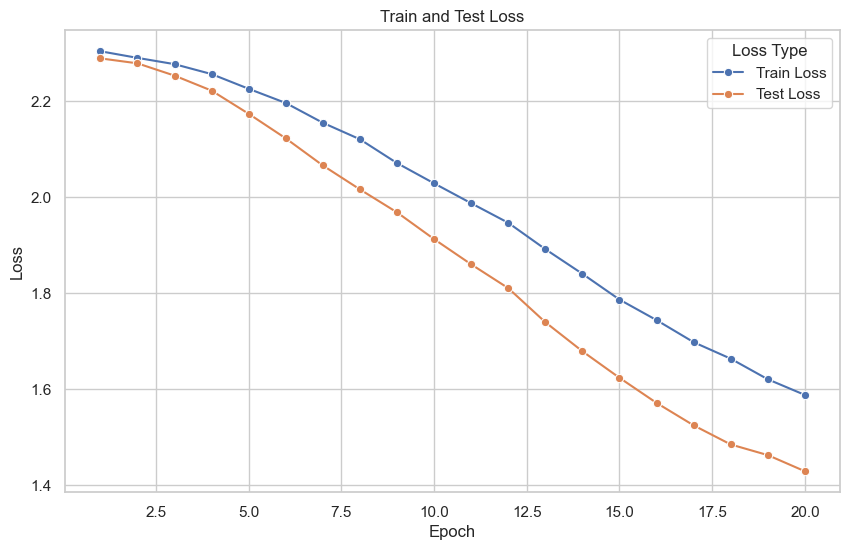

In [23]:
data = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                     'Train Loss': train_loss,
                     'Test Loss': test_loss})

data_melted = pd.melt(data, id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Loss', hue='Loss Type', data=data_melted, marker='o')
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Loss Type')
plt.show()

In [24]:
PATH = r".\alexnet_imagenette.pth"
torch.save(net.state_dict(), PATH)

## Evaluation

In [25]:
net.eval()
    
for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)
    predictions = net(inputs)
    accuracy = metric(labels, predictions.argmax(dim=-1))
    
top_5_accuracy = metric.compute()
print(f"Accuracy on all data: {accuracy}")

Accuracy on all data: 0.4285714328289032
